In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import math
import glob
import re
import contextlib
import itertools
import collections
from collections.abc import Mapping
import numpy as np
from numpy import random
import pandas as pd
import tqdm
import torch 
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from datasets import Dataset
from sklearn import linear_model
import sklearn
from sklearn import pipeline
import scipy
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine as p9
import seaborn as sns

In [2]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, top_k_accuracy_score, roc_curve

In [4]:
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}
def revcomp(seq):
    return "".join([nuc_to_revcomp[x] for x in seq][::-1])


def plot_with_nucs(start, end, snp_effect, sequence, vmax=None, remove_diag=True, size=None, savepath=None, cbar=True):
    fig, ax = plt.subplots()
    if size is not None:
        fig.set_size_inches(size,size)
    
    matrix = snp_effect[start:end,start:end].numpy(force=True)
    if remove_diag:
        np.fill_diagonal(matrix,0)
    ax = sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, cbar=cbar)

    tick_positions = np.arange(len(sequence[start:end])) + 0.5 # Center the ticks
    ax.set_aspect('equal')
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    ax.set_xticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    ax.set_yticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    
    if savepath is not None:
        fig.savefig(savepath, dpi=300)

In [5]:
def create_diag_mask(mask_width = 9, matrix_size = 5): 

    mask = np.zeros((matrix_size, matrix_size))

    for k in range(-mask_width // 2 + 1, mask_width // 2 + 1):
        mask += np.diag(np.ones(matrix_size - abs(k)), k=k)

    mask = 1 - mask
    return mask

def get_triangular_values(matrix):
    
    triang_mask = np.tri(matrix.shape[0],k=-1, dtype=bool)
    
    triangular_flattened = matrix[triang_mask]
    
    return triangular_flattened

def process_ci_matrix(matrix, mask_diag=9, get_max_ij_ji=True):

    if get_max_ij_ji:
        matrix = np.maximum(matrix, matrix.T)
    if mask_diag is not None:
        matrix = matrix * create_diag_mask(mask_width = mask_diag, matrix_size = matrix.shape[0])

    return matrix

def keepmaxperpos(non_diag_ci_matrix):
    #get the max values per row and mask the other values to 0
    max_values = np.max(non_diag_ci_matrix, axis=1, keepdims=True)
    mask = non_diag_ci_matrix == max_values
    non_diag_ci_matrix = non_diag_ci_matrix * mask
    return non_diag_ci_matrix

def create_contact_matrix(structure):
    stack = []
    matrix_size = len(structure)
    contact_matrix = torch.zeros((matrix_size, matrix_size), dtype=int)

    for i, char in enumerate(structure):
        if char == '>':
            stack.append(i)
        elif char == '<' and stack:
            j = stack.pop()
            contact_matrix[i,j] = contact_matrix[j,i] = 1

    return contact_matrix

In [6]:
def plot_ncrna_structure(row, base_path, normalize=False, plot=False, revcomp=False,vmax=5):
    # Get ci matrix
    ci_matrix = torch.load("{}_{}.pt".format(base_path, row["Name"])).nan_to_num(0).numpy()
    if normalize:
        for axis in range(2):
            ci_matrix = ci_matrix - ci_matrix.mean(axis=axis, keepdims=True)
    if revcomp:
        ci_matrix = np.flip(ci_matrix,axis=(0,1))
    #ci_matrix_values = get_triangular_values(keepmaxperpos(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=9)))
    ci_matrix_values = get_triangular_values(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=1))
    # Get true matrix
    obs_matrix = create_contact_matrix(row["Str"])
    obs_values = get_triangular_values(obs_matrix)
    # Eval
    p,r,_ = precision_recall_curve(obs_values, ci_matrix_values)
    auprc = auc(r, p)
    auroc = roc_auc_score(obs_values, ci_matrix_values)
    if plot:
        # Plot
        plt.subplot(1, 4, 1)
        plot_ci_matrix(ci_matrix, vmax=vmax)
        plt.title("Predicted")
        plt.subplot(1, 4, 3)
        plot_ci_matrix(obs_matrix, vmax=vmax)
        plt.title("Annotation")
        plt.subplot(1, 4, 4, box_aspect=1)
        plt.plot(r, p)
        plt.title("AUC = %1.3f" % (auprc))
        plt.tight_layout()
        plt.show()
    return auprc, auroc

In [7]:
def plot_ci_matrix(ci_matrix, dna_seq, plot_size = 10, tick_label_fontsize = 8, filename=None, savefig=False, dpi=300, vmax=5, color_label_name='Dependency'):
    plt.figure(figsize=(plot_size, plot_size))
    plt.imshow(ci_matrix, cmap="coolwarm",vmax=vmax)

    cbar = plt.colorbar(shrink=0.3)  # Adjust 'shrink' to control the size of the colorbar
    cbar.ax.tick_params(labelsize=20)  # Adjust label size of colorbar
    cbar.set_label(color_label_name, fontsize=20)
    
    plt.gca().set_aspect('equal')

    tick_positions = np.arange(len(dna_seq)) 
    plt.xticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    plt.yticks(tick_positions, list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
    
    #plt.savefig(os.path.join(project_path, 'ci_matrices/dna-lm-interactions-paper/figures/fig7_trna.png'), dpi=500)
    plt.show()

def plot_ncrna_structure(row, base_path, normalize=False, plot=False, revcomp=False,vmax=5):
    # Get ci matrix
    ci_matrix = torch.load("{}_{}.pt".format(base_path, row["Name"])).nan_to_num(0).numpy()
    if normalize:
        for axis in range(2):
            ci_matrix = ci_matrix - ci_matrix.mean(axis=axis, keepdims=True)
    if revcomp:
        ci_matrix = np.flip(ci_matrix,axis=(0,1))
    #ci_matrix_values = get_triangular_values(keepmaxperpos(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=9)))
    ci_matrix_values = get_triangular_values(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=1))
    # Get true matrix
    obs_matrix = create_contact_matrix(row["Str"])
    obs_values = get_triangular_values(obs_matrix)
    # Eval
    p,r,_ = precision_recall_curve(obs_values, ci_matrix_values)
    auprc = auc(r, p)
    auroc = roc_auc_score(obs_values, ci_matrix_values)
    if plot:
        # Plot
        plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
        ci_matrix[np.arange(ci_matrix.shape[0]), np.arange(ci_matrix.shape[0])] = 0
        plot_ci_matrix(ci_matrix,row.Seq.upper(), vmax=vmax)
        
        plot_ci_matrix(obs_matrix, row.Seq.upper(),vmax=1, color_label_name='Contacts')
                
        plt.tight_layout()
    return auprc, auroc

# Human

In [1]:
base_path = '/s/project/semi_supervised_multispecies/Downstream/tRNA'

In [9]:
trna_df = pd.read_csv(os.path.join(data_path, "human_trna.tsv"),sep="\t")

In [10]:
trna_df

,Name,id,Seq,Str,Chromosome,Start,End,Strand,seqlen,genomic_seq,context_len,start_in_context,end_in_context
0,tRNA-Gly-CCC-1-2,chr1.trna4,GCATTGGTGGTTCAGTGGTAGAATTCTCGCCTCCCACGCGGGAGaC...,>>>>>>>..>>>>.......<<<<.>>>>>.......<<<<<.......,chr1,16861920,16861991,+,71,GTATTTCCTTTAAAAAAAAAAAAAGTTAACTACAAAAATGTAGTTA...,132000,66000,66071
1,tRNA-Glu-TTC-3-1,chr1.trna5,TCCCTGGTGGTCTAGTGGCtAGGATTCGGCGCTTTCACCGCCGCGG...,>>>>>>>..>>>>........<<<<.>>>>>.......<<<<<......,chr1,16872582,16872654,+,72,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,132000,66000,66072
2,tRNA-Asn-GTT-4-1,chr1.trna7,GTCTCTGTGGCGCAATCGGTtAGCGCGTTCGGCTGTTAACCGAAAG...,>>>>>>>..>>>>.........<<<<.>>>>>.......<<<<<.....,chr1,16889676,16889750,+,74,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,132000,66000,66074
3,tRNA-Arg-TCT-1-1,chr1.trna9,GGCTCCGTGGCGCAATGGAtAGCGCATTGGACTTCTAgaggctgaa...,>>>>>>>..>>>>........<<<<.>>>>>..................,chr1,93847572,93847657,+,85,TTACAGATGATGAAAACAGGGCTCTGGGAGGATAACCTGCCTGAGG...,132000,66000,66085
4,tRNA-Gln-CTG-4-2,chr1.trna12,GGTTCCATGGTGTAATGGTaAGCACTCTGGACTCTGAATCCAGCGa...,>>>>>>>..>>>>........<<<<.>>>>>.......<<<<<......,chr1,143691473,143691545,+,72,GCCTTCTCAGCTCAGTGGGGATGCCCTGCTCTGAGAGGACTCTAGC...,132000,66000,66072
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,tRNA-Met-CAT-1-1,chr8.trna8,GCCTCGTTAGCGCAGTAGGTAGCGCGTCAGTCTCATAATCTGAAGG...,>>>>>>>..>>>>........<<<<.>>>>.........<<<<......,chr8,123157229,123157302,-,73,GGGTATATACCTAGGAGTAGAATTACTGGGTCATATATTAGCTCTG...,132000,66000,66073
262,tRNA-Tyr-GTA-9-1,chr8.trna12,TCTTCAATAGCTCAGCTGGTAGAGCGGAGGACTGTAGgtgcacgcc...,>>>>>>>..>>>>........<<<<.>>>>>..................,chr8,65697296,65697384,-,88,CATGTTGGTCAGGCTGGTCTCGAACTTCTGACCTCAGGTGATCCAC...,132000,66000,66088
263,tRNA-Arg-TCG-6-1,chr9.trna4,GGCCGTGTGGCCTAATGGAtAAGGCGTCTGACTTCGGATCAAAAGA...,>>>>>>>..>>>>........<<<<.>.>>>.......<<<.<......,chr9,110198522,110198595,+,73,TTTCACCATGTTGGTCAGGCTGGTCTCAAACTCCTGACCTCAAGTG...,132000,66000,66073
264,tRNA-Arg-TCT-3-1,chr9.trna5,GGCTCTGTGGCGCAATGGAtAGCGCATTGGACTTCTAgctgagcct...,>>>>>>>..>>>>........<<<<.>>>>>..................,chr9,128340075,128340166,-,91,TGGGGGTCTTGGGGAGCCCCGACATGGACAACCTCTCCCTCCCTCA...,132000,66000,66091


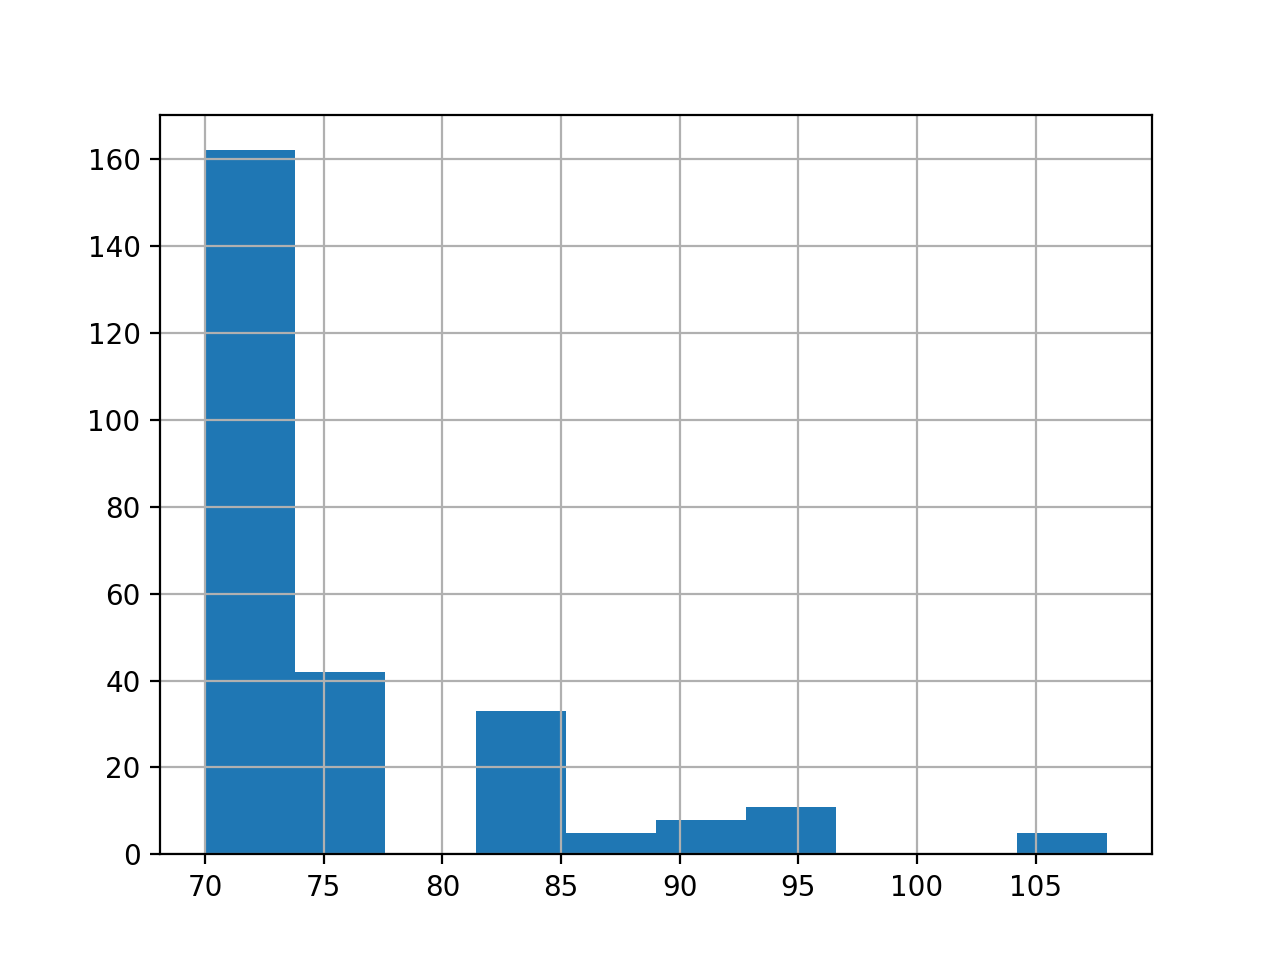

In [68]:
trna_df['Seq'].apply(lambda el: len(el)).hist()
plt.show()

In [79]:
model_to_path = {#the maps computed for different models are stored in Results/Human 
                 "Hyena":"Results/Human/Hyena_nocontext",
                 "DNA-BERT":"Results/Human/DNABERT_500b",
                 "NT-HumanRef":"Results/Human/NTRef_6kb",
                 "NT-Human1000G":"Results/Human/NT1000G_6kb",
                 "NT-Human1000G-2.5B":"Results/Human/NT1000GBig_6kb",
                 "CaduceusPS":"Results/Human/Caduceus_131kb",
                 "PlantCaduceus":"Results/Human/PlantCaduceus_512b",
                 "NT":"Results/Human/NTBig_6kb",
                 "NTv2":"Results/Human/NTv2_12kb",
                 "Evo":"Results/Human/Evo_nocontext",
                 "SpeciesLM\nFungi":"Results/Human/SpeciesK1_1kb",
                 "RiNALMo":"Results/Human/RiNALMo_nocontext",
                }

metrics_rows = []
for model in model_to_path.keys():
    for _, row in tqdm.tqdm(trna_df.iterrows()):
        auprc, auroc = plot_ncrna_structure(row, base_path=os.path.join(base_path, model_to_path[model]), plot=False)
        metrics_rows.append({"Model":model,"tRNA":row["Name"],"AUPRC":auprc,"AUROC":auroc})
trna_metrics_human = pd.DataFrame(metrics_rows)

266it [00:01, 186.13it/s]
266it [00:01, 191.44it/s]
266it [00:01, 195.90it/s]
266it [00:01, 190.32it/s]
266it [00:01, 193.07it/s]
266it [00:01, 195.19it/s]
266it [00:01, 193.99it/s]
266it [00:01, 196.14it/s]
266it [00:01, 191.11it/s]
266it [00:01, 184.36it/s]
266it [00:01, 194.06it/s]
266it [00:01, 191.36it/s]


In [85]:
model_order = list(model_to_path.keys())[::-1]

plot_df = trna_metrics_human.copy()
plot_df["Model"] = pd.Categorical(plot_df["Model"], categories=['DNA-BERT', 'Hyena', 'CaduceusPS', 'NT-Human1000G-2.5B',
                  'NT-HumanRef', 'NT-Human1000G', 'PlantCaduceus', 'NT',
                  'NTv2', 'Evo', 'RiNALMo', 'SpeciesLM\nFungi'][::-1], ordered=True)

plot_df["SeC"] = plot_df["tRNA"].apply(lambda x: "SeC" if "SeC" in x else "Canonical")

In [87]:
model_label = {
    "Hyena":"Human",
    "DNA-BERT":"Human",
    "NT-HumanRef":"Human",
    "NT-Human1000G":"Human",
    "NT-Human1000G-2.5B":"Human",
    "PlantCaduceus":"Multispecies",
    "CaduceusPS":"Human",
    "NT":"Multispecies",
    "NTv2":"Multispecies",
    "Evo":"Multispecies",
    "SpeciesLM\nFungi":"Multispecies",
    "RiNALMo":"Multispecies",
}

plot_df["Model_Type"] = plot_df["Model"].apply(lambda x: model_label[x])
plot_df["Model_Type"] = pd.Categorical(plot_df["Model_Type"], categories=["Human","Multispecies"][::-1])

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4.5 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig7_model_comparison_auroc_updated.png


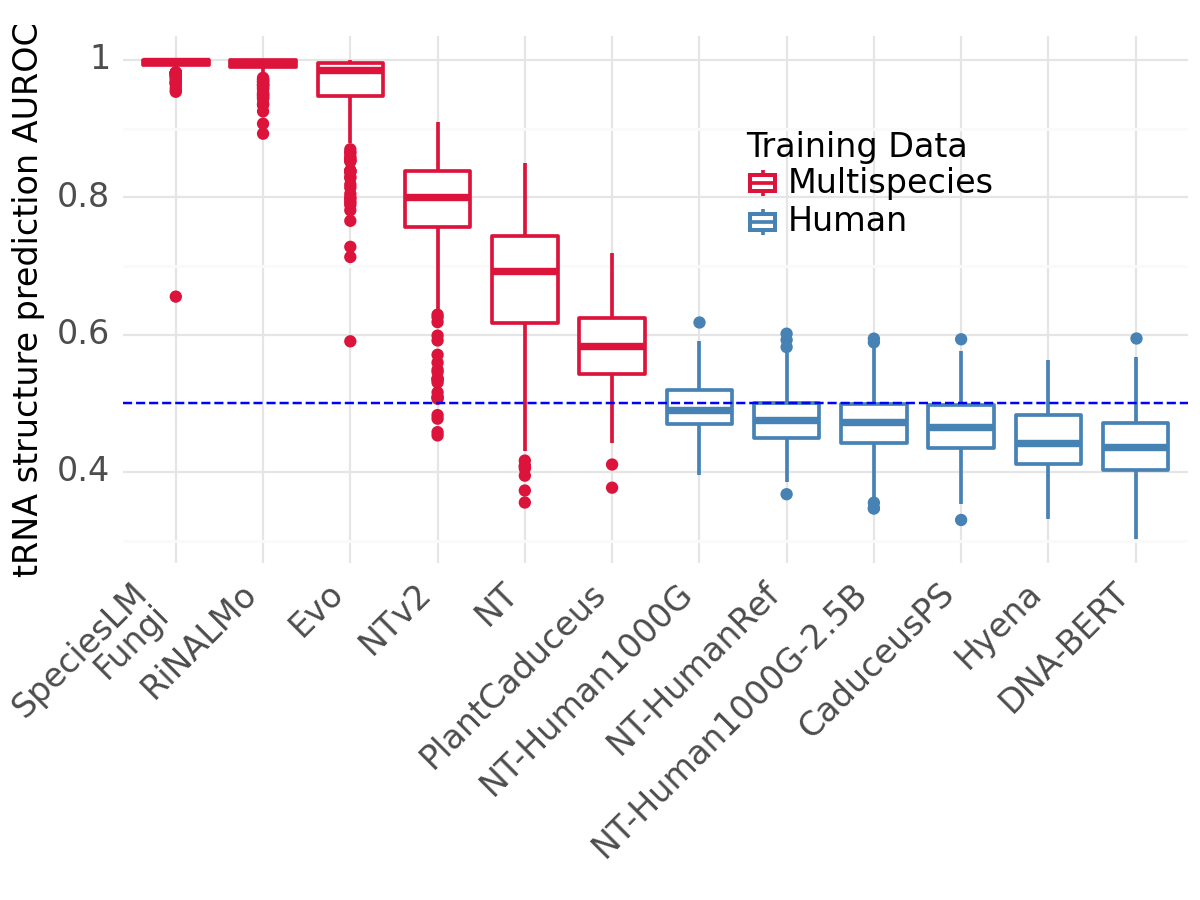

<Figure Size: (600 x 450)>

In [95]:
fontsize=12
p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="Model",y="AUROC")) 
 #+ p9.geom_boxplot(outlier_shape="", mapping = p9.aes(color="Model_Type"), size=0.75) 
 +  p9.geom_boxplot(mapping = p9.aes(color="Model_Type"), size=0.75) 
 #+ p9.geom_jitter(width=0.125, size=1, alpha=0.2)#, mapping = p9.aes(color="Model_Type"))
 #+ p9.geom_jitter(mapping = p9.aes(fill="SeC", alpha="SeC"),width=0.125, size=1)
 #+ p9.scale_fill_manual(["grey","blue"])
 #+ p9.scale_alpha_manual([0.3,1])
 + p9.scale_color_manual(["crimson","steelblue"])
 + p9.labs(x="",y="tRNA structure prediction AUROC", color="Training Data")
 + p9.theme_minimal()
 + p9.geom_hline(yintercept=0.5, linetype='dashed', color='blue') 
  + p9.theme(legend_text = p9.element_text(size=fontsize),
        legend_key_size=fontsize,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=fontsize),
        legend_position=(0.725,0.8), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=fontsize),
        axis_text=p9.element_text(size=fontsize),
        axis_text_x=p9.element_text(rotation=45, hjust=1),
        figure_size=(6,4.5)
       )
)

p.save('fig7_model_comparison_auroc.png', dpi=500)

p

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4.5 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig7_model_comparison_auprc.png


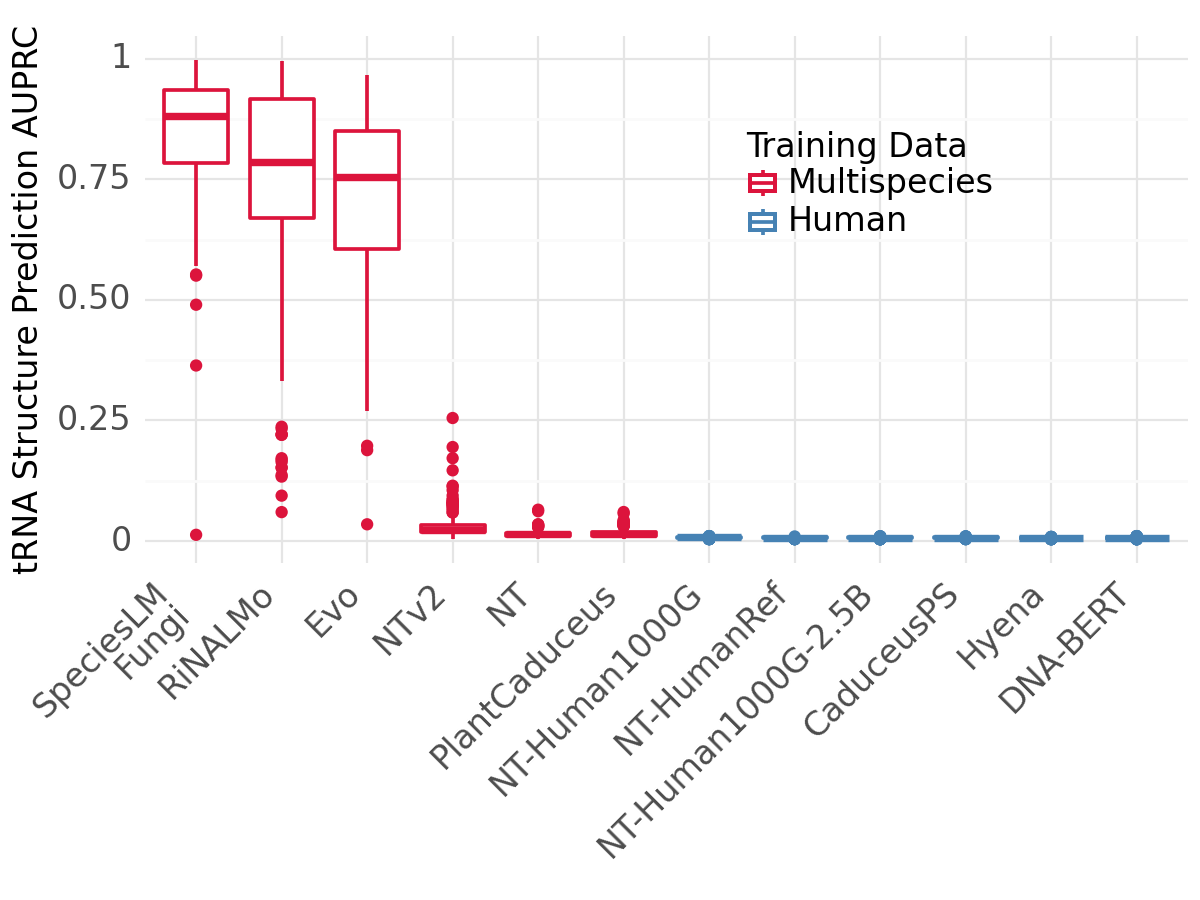

<Figure Size: (600 x 450)>

In [96]:
fontsize=12

p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="Model",y="AUPRC")) 
 #+ p9.geom_boxplot(outlier_shape="", mapping = p9.aes(color="Model_Type"), size=0.75) 
 +  p9.geom_boxplot(mapping = p9.aes(color="Model_Type"), size=0.75) 
 #+ p9.geom_jitter(width=0.125, size=1, alpha=0.2)#, mapping = p9.aes(color="Model_Type"))
 #+ p9.geom_jitter(mapping = p9.aes(fill="SeC", alpha="SeC"),width=0.125, size=1)
 #+ p9.scale_fill_manual(["grey","blue"])
 #+ p9.scale_alpha_manual([0.3,1])
 + p9.scale_color_manual(["crimson","steelblue"])
 + p9.labs(x="",y="tRNA Structure Prediction AUPRC", color="Training Data")
 + p9.theme_minimal()
 #+ p9.geom_hline(yintercept=0.5, linetype='dashed', color='blue') 
  + p9.theme(legend_text = p9.element_text(size=fontsize),
        legend_key_size=fontsize,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=fontsize),
        legend_position=(0.725,0.8), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=fontsize),
        axis_text=p9.element_text(size=fontsize),
        axis_text_x=p9.element_text(rotation=45, hjust=1),
        figure_size=(6,4.5)
       )
)

p.save('fig7_model_comparison_auprc.png', dpi=500)

p

4


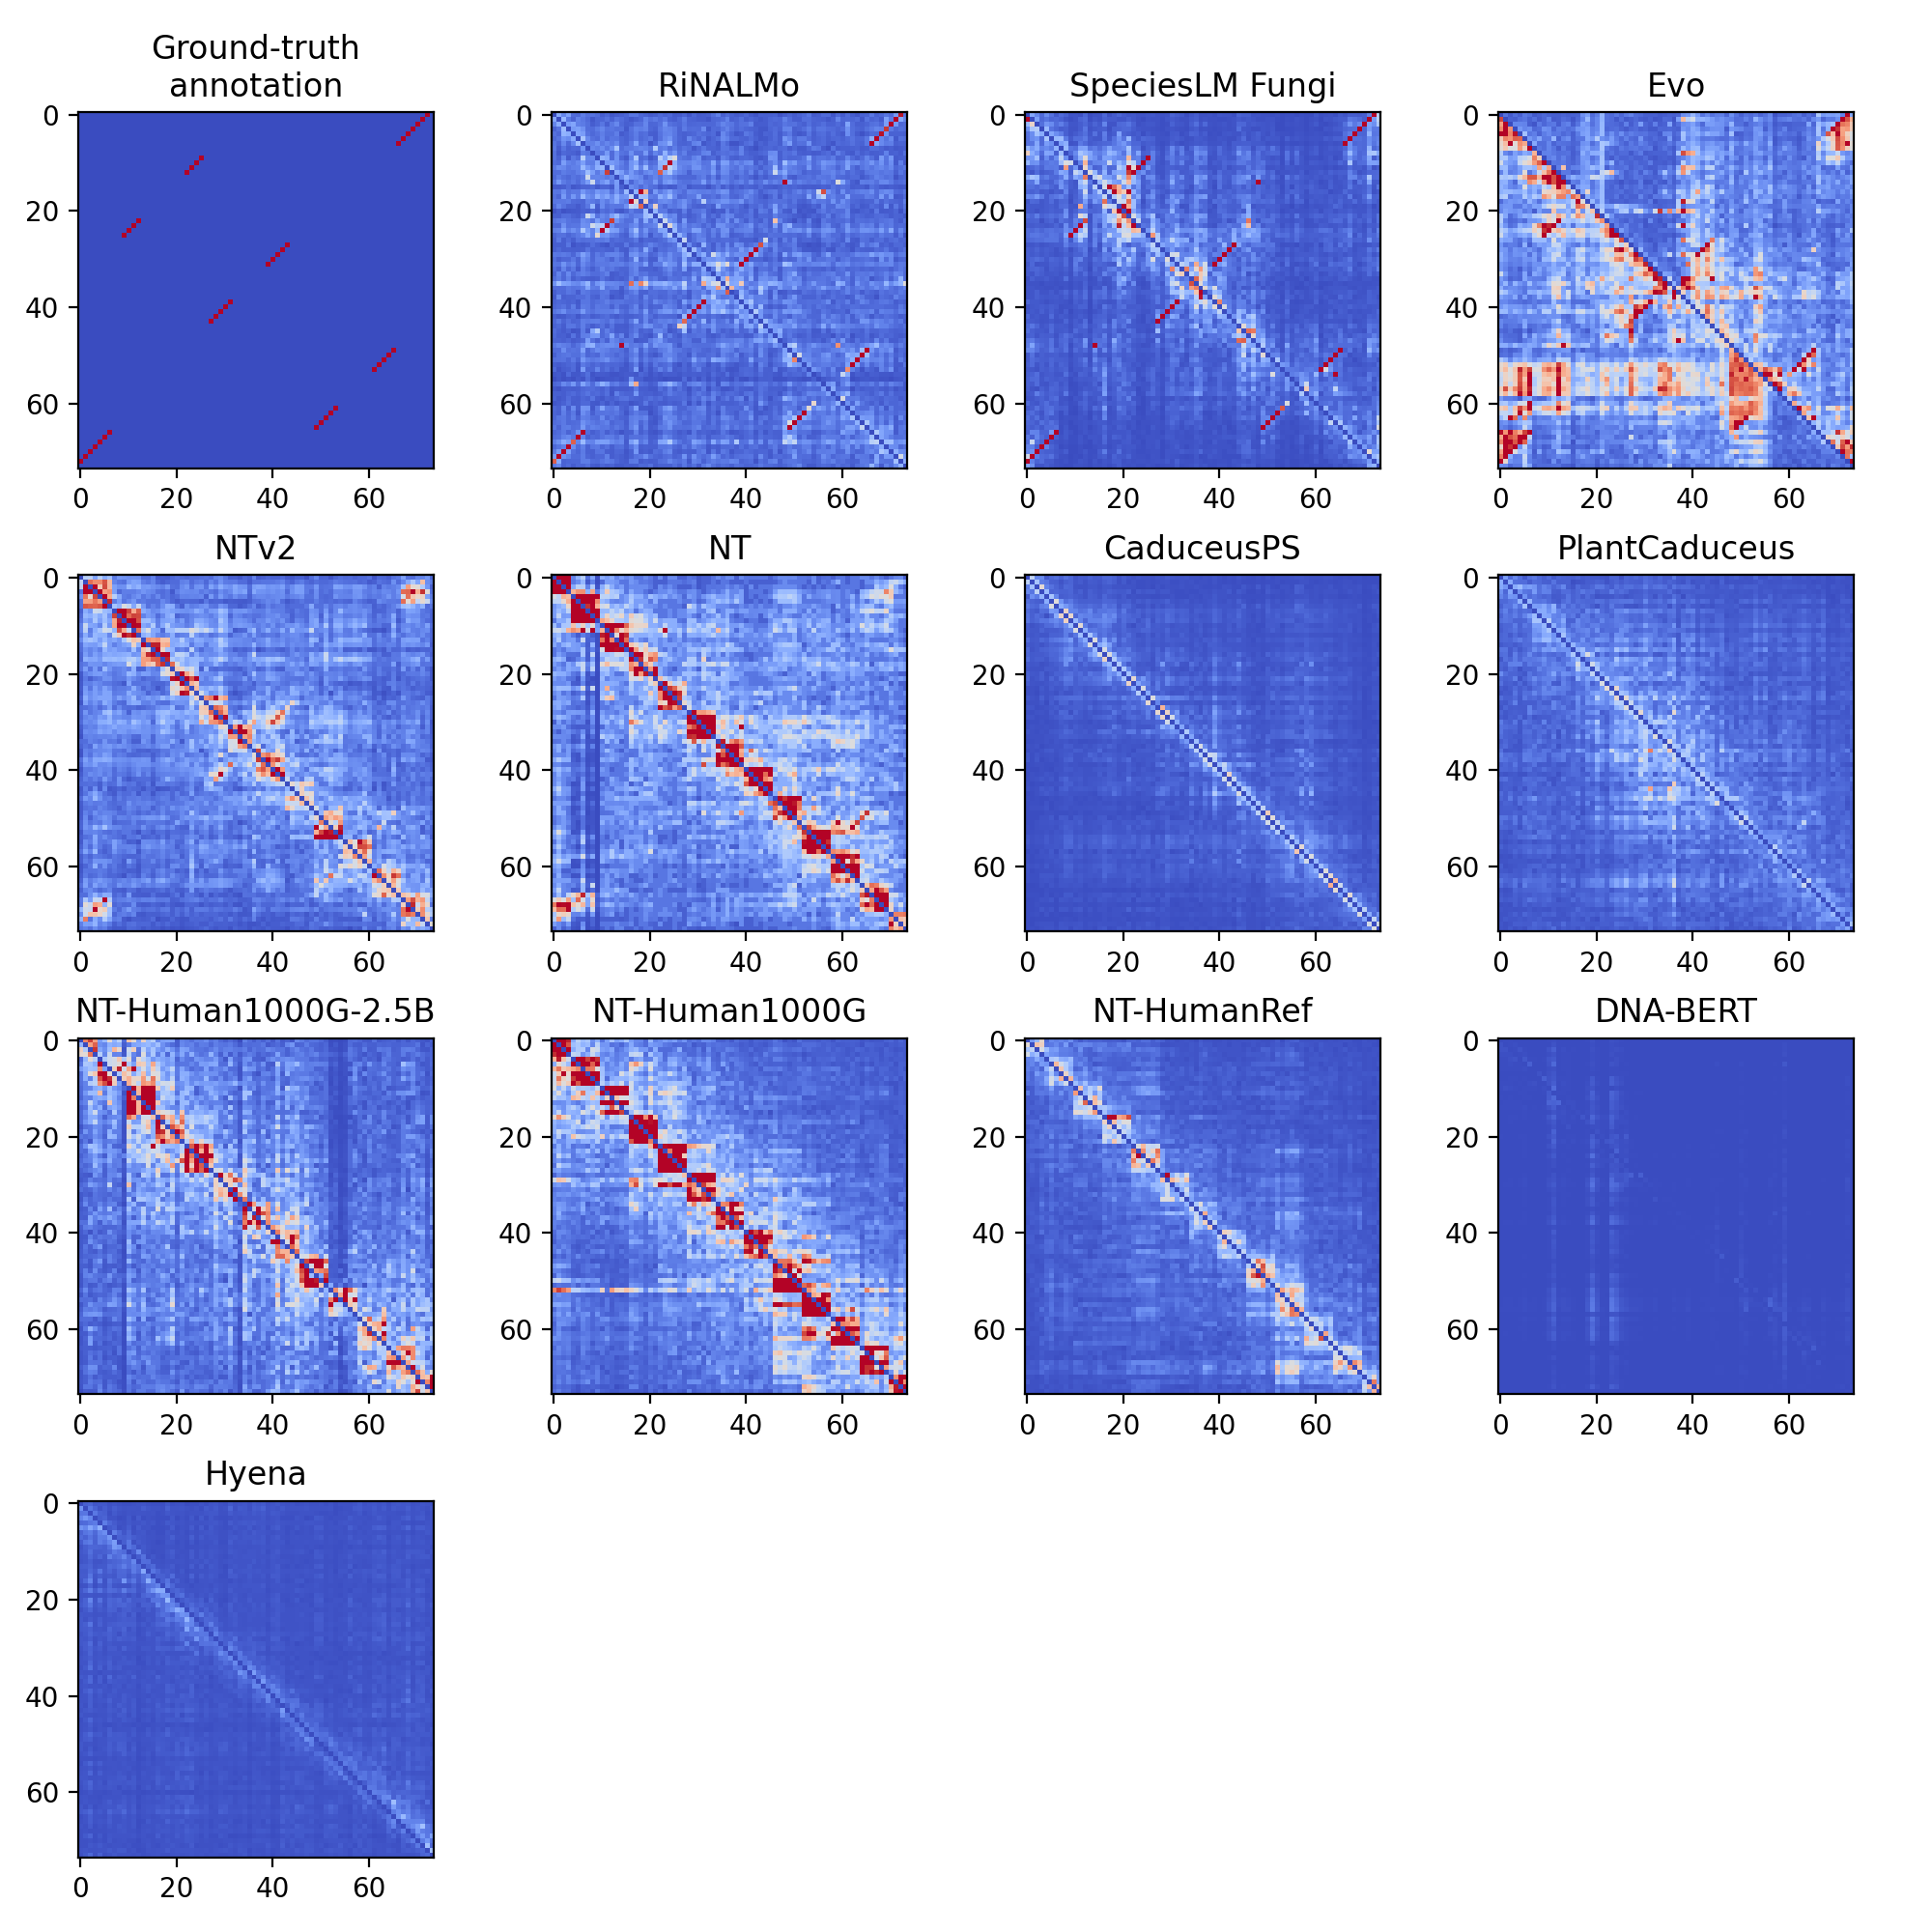

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
import os

def plot_ci_matrix(ci_matrix, dna_seq, ax, plot_size=10, tick_label_fontsize=8, vmax=5, color_label_name='Dependency',show_color_legend=True, show_seq=True):
    im = ax.imshow(ci_matrix, cmap="coolwarm", vmax=vmax)
    
    if show_color_legend:
        cbar = plt.colorbar(im, ax=ax, shrink=0.2)  # Adjust 'shrink' to control the size of the colorbar
        cbar.ax.tick_params(labelsize=12)  # Adjust label size of colorbar
        cbar.set_label(color_label_name, fontsize=12)
    
    ax.set_aspect('equal')

    if show_seq:
        tick_positions = np.arange(len(dna_seq))
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(list(dna_seq), fontsize=tick_label_fontsize, rotation=0)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(list(dna_seq), fontsize=tick_label_fontsize, rotation=0)

def plot_ncrna_structure(row, base_path, normalize=False, plot=False, revcomp=False, vmax=5):
    ci_matrix = torch.load("{}_{}.pt".format(base_path, row["Name"])).nan_to_num(0).numpy()
    if normalize:
        for axis in range(2):
            ci_matrix = ci_matrix - ci_matrix.mean(axis=axis, keepdims=True)
    if revcomp:
        ci_matrix = np.flip(ci_matrix, axis=(0, 1))
    ci_matrix_values = get_triangular_values(find_best_pairs(process_ci_matrix(ci_matrix, get_max_ij_ji=True, mask_diag=9)))
    obs_matrix = create_contact_matrix(row["Str"])
    obs_values = get_triangular_values(obs_matrix)
    p, r, _ = precision_recall_curve(obs_values, ci_matrix_values)
    auprc = auc(r, p)
    auroc = roc_auc_score(obs_values, ci_matrix_values)
    ci_matrix[np.arange(ci_matrix.shape[0]),np.arange(ci_matrix.shape[0])]=0
    return ci_matrix, obs_matrix, auprc, auroc

def plot_models_grid(models, model_to_path, row, figsize=20,show_color_legend=True, show_seq=True, save_path=None):
    ncols = 4
    nrows = (len(models) + ncols - 1) // ncols +1# Calculate the number of rows needed
    print(nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize, (figsize/4) * nrows))
    
    # Plot the annotation matrix in the top left
    obs_matrix = create_contact_matrix(row["Str"])
    plot_ci_matrix(obs_matrix, row['Seq'].upper(), ax=axes[0, 0], vmax=1, color_label_name='Contacts', show_color_legend=show_color_legend, show_seq=show_seq)
    axes[0, 0].set_title("Ground-truth\nannotation",fontsize=12)
    
    # Remove empty subplots
    #for j in range(1, ncols + 1):
    #    fig.delaxes(axes[0, j])
    
    for i, model in enumerate(models):
        row_idx = (i + 1) // (ncols)
        col_idx = (i + 1) % (ncols)

        base_path_model = model_to_path[model]
        ci_matrix, _, auprc, auroc = plot_ncrna_structure(row, os.path.join(base_path, base_path_model), plot=False)
        
        plot_ci_matrix(ci_matrix, row['Seq'].upper(), ax=axes[row_idx, col_idx], vmax=5, color_label_name='Dependency',show_color_legend=show_color_legend, show_seq=show_seq)
        axes[row_idx, col_idx].set_title(f"{model}", fontsize=12)
    
    # Remove empty subplots
    total_plots = nrows * ncols
    models_plotted = len(models) + 1  # +1 for the annotation plot
    for i in range(models_plotted, total_plots):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0,left=0.01, right=0.99)  # Adjust hspace and wspace to control spacing
    
    plt.savefig(save_path, dpi=500) if save_path is not None else None

    plt.show()
    
# Example usage
plot_models_grid(list(model_label.keys())[::-1], model_to_path, trna_df[trna_df.Name == 'tRNA-Arg-TCT-4-1'].iloc[0],figsize=10,
                 show_color_legend=False, show_seq=False, save_path = os.path.join('/s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig7_model_comparison_tRNA.png'))


In [42]:
models_to_plot = ['RiNALMo','SpeciesLM Fungi',
 'Evo',
 'NTv2',
 'NT-Human1000G-2.5B',
 'NT-HumanRef',
 'Hyena']

3


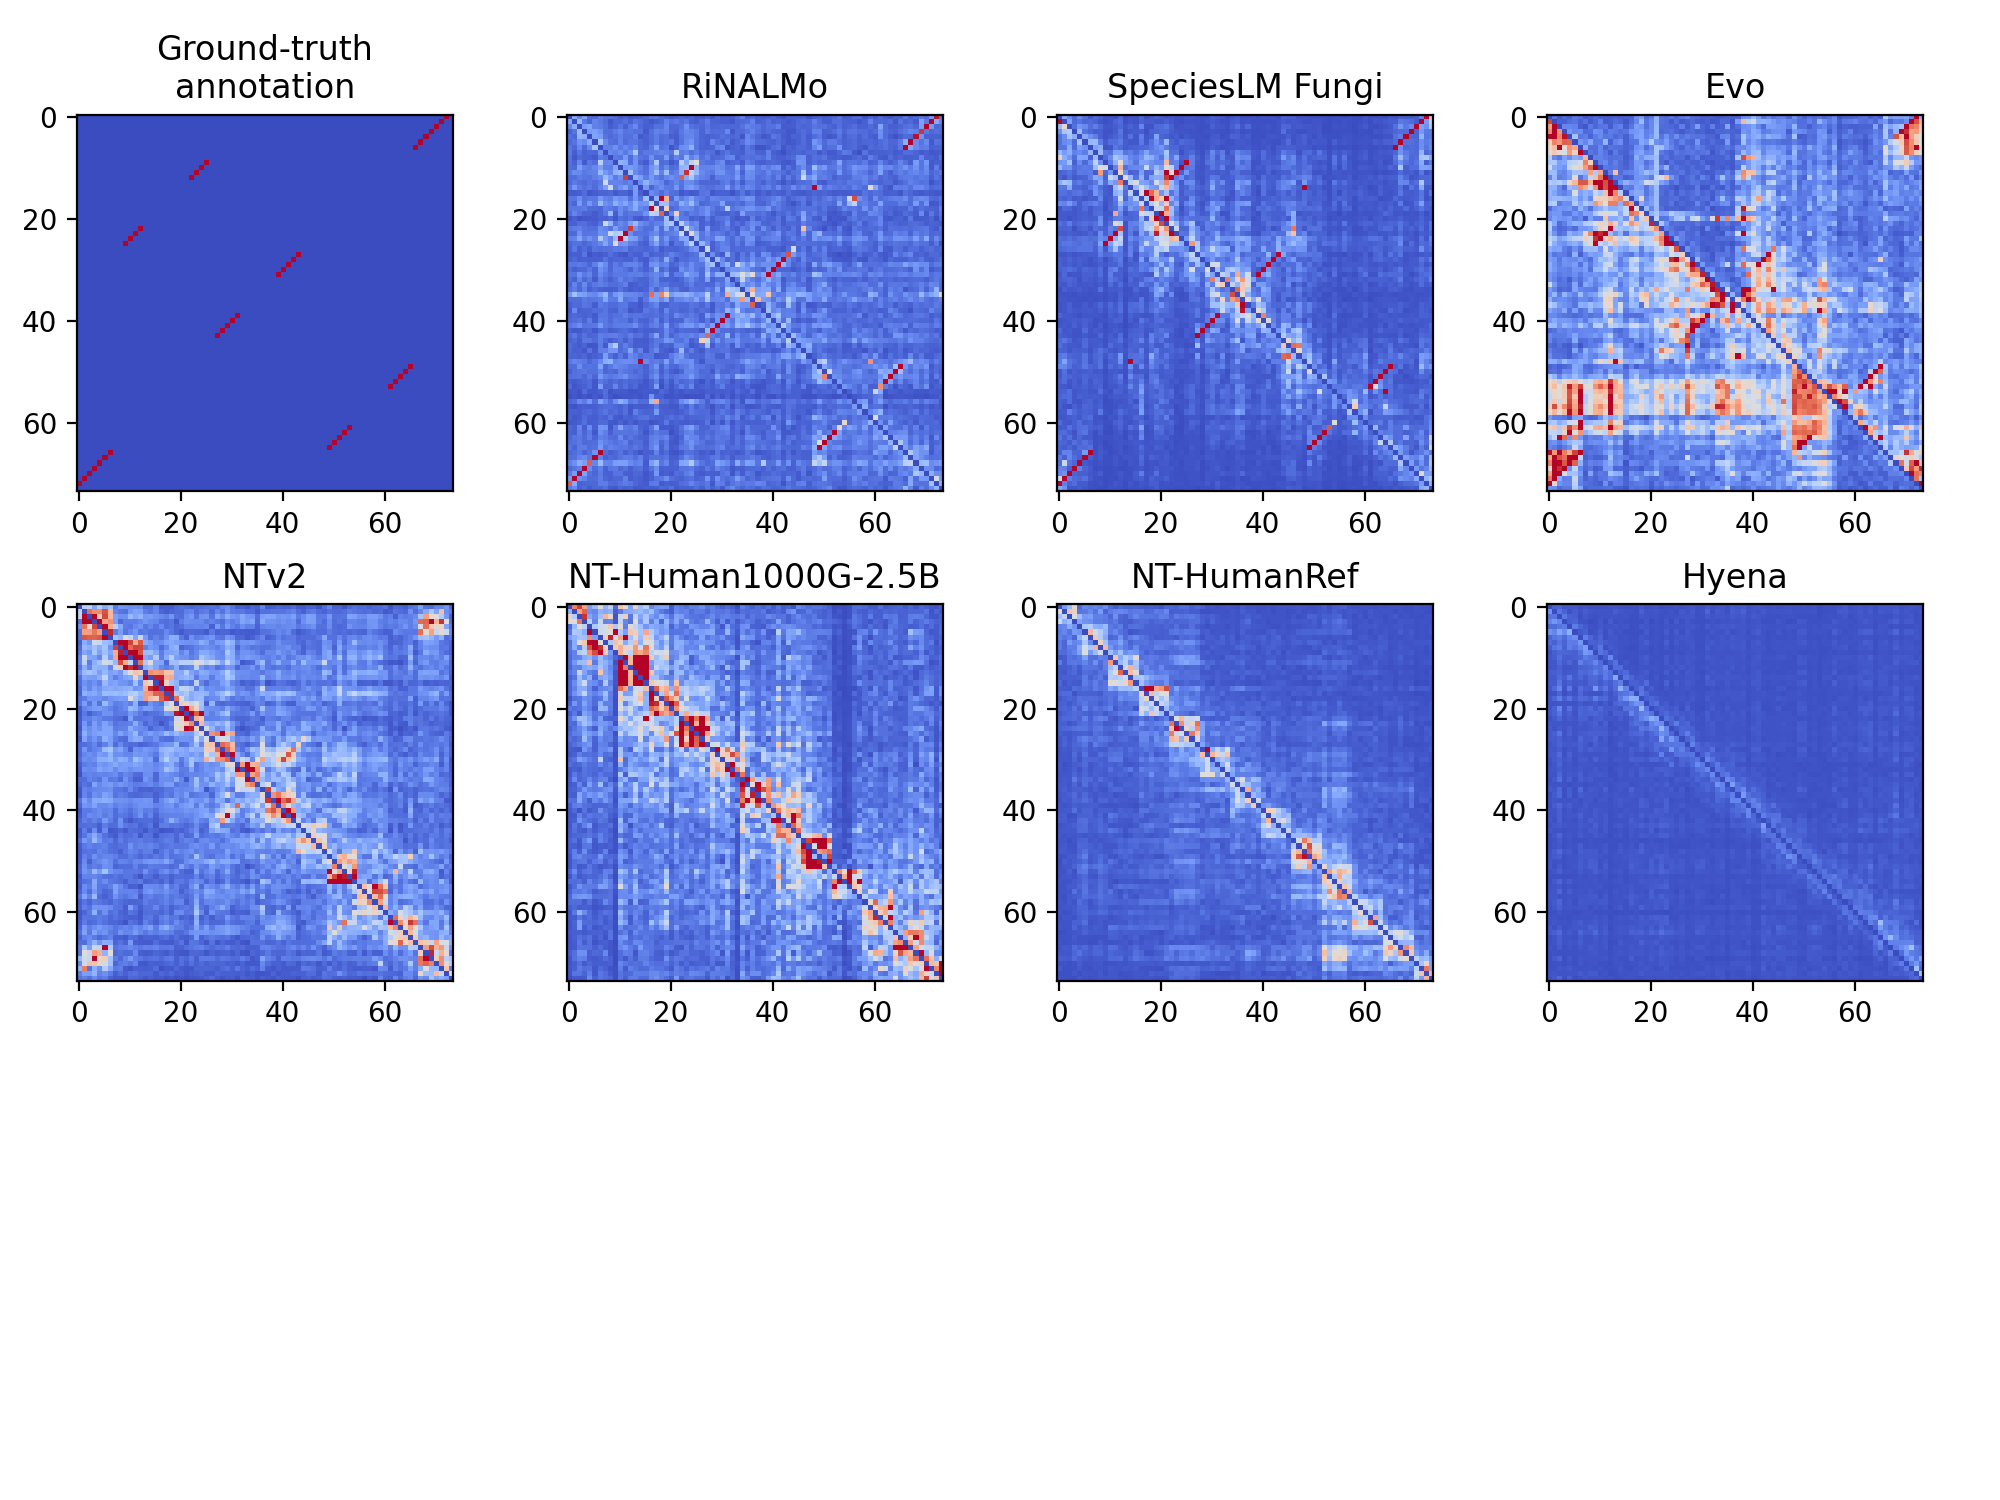

In [43]:
plot_models_grid(models_to_plot, model_to_path, trna_df[trna_df.Name == 'tRNA-Arg-TCT-4-1'].iloc[0],figsize=10,
                 show_color_legend=False, show_seq=False, save_path = os.path.join('/s/project/multispecies/fungi_code/ci_matrices/dna-lm-interactions-paper/figures/fig7_model_comparison_tRNA.png'))